In [ ]:
## mount gdrive
import os
from google.colab import drive
drive.mount('/content/drive/')
# Check if a GPU is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Mounted at /content/drive/
Device: cuda


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from skimage.transform import radon
import torchvision
import os
import pickle
import random
import numpy as np
import gzip
import torchvision.datasets as datasets
from torchvision import transforms
transform = torchvision.transforms.Compose([transforms.ToTensor()])

#### some data-loading functionalities
datapath = '/content/drive/My Drive/assistant_prof_jobs_documents/IIT-Kgp ECE job/teaching@IITKgp/cambridge_IA_minor_2025/coursework_codes/practical_codes/mnist_dataset'
full_trainset = datasets.MNIST(root=datapath, train=True, download=True, transform=transform)
full_testset = datasets.MNIST(root=datapath, train=False, download=True, transform=transform)
print('total #train images: {}, #test images: {}'.format(len(full_trainset), len(full_testset)))

#### we will create a small subset of MNIST for both training and testing
random_sampler_train = torch.utils.data.RandomSampler(full_trainset, num_samples=2000)
train_dataloader = torch.utils.data.DataLoader(full_trainset, batch_size=64, sampler=random_sampler_train)

random_sampler_test = torch.utils.data.RandomSampler(full_testset, num_samples=100)
test_dataloader = torch.utils.data.DataLoader(full_testset, batch_size=20, sampler=random_sampler_test)

total #train images: 60000, #test images: 10000


In [ ]:
### forward operator and the adjoint for inpainting
# mask = torch.rand(1,1,28,28).to(device)
# mask = mask < 0.4

mask = torch.ones(1,1,28,28).to(device)
mask[:,:,8:20,8:20] = 0

def forward(x):
    return x*mask
fwd_op = forward
adj_op = forward

In [ ]:
### create the networks
import torch.nn as nn
class prox_net_dual(nn.Module):
    def __init__(self, n_in_channels=3, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(prox_net_dual, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)


    def forward(self, h, y, z):
        dh = torch.cat((h, y, z), dim=1)
        dh = self.act1(self.conv1(dh))
        dh = self.act2(self.conv2(dh))
        dh = self.conv3(dh)
        return h + dh

class prox_net_primal(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(prox_net_primal, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)

    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return x + dx

class LPD(nn.Module):
    def __init__(self, fwd_op, adjoint_op, niter=5, sigma=0.01, tau=0.01):
        super(LPD, self).__init__()

        self.fwd_op = fwd_op
        self.adj_op = adj_op
        self.niter = niter
        self.sigma = nn.Parameter(sigma * torch.ones(self.niter).to(device))
        self.tau = nn.Parameter(tau * torch.ones(self.niter).to(device))
        self.cnn_image_layers = nn.ModuleList([prox_net_primal().to(device) for i in range(self.niter)])
        self.cnn_data_layers = nn.ModuleList([prox_net_dual().to(device) for i in range(self.niter)])

    def forward(self, y, x_init):
        x = x_init
        h = torch.zeros_like(y)
        for iteration in range(self.niter):
            h = self.cnn_data_layers[iteration](h, y, self.sigma[iteration] * self.fwd_op(x))
            x = self.cnn_image_layers[iteration](x, self.tau[iteration] * self.adj_op(h))
        return x


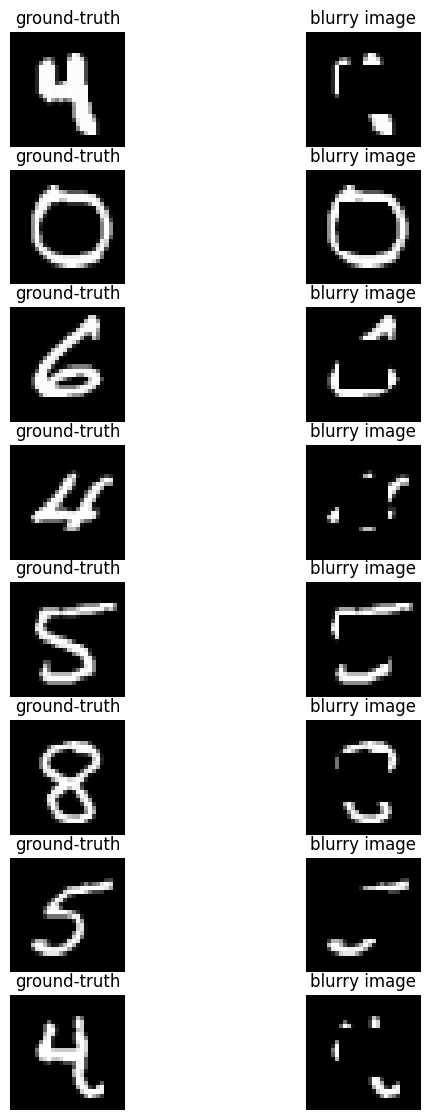

In [ ]:
#### Let's visualize some of the training images
import matplotlib.pyplot as plt
for batch_idx, (x_true, _) in enumerate(train_dataloader):
  x_true = x_true.to(device)
  y = fwd_op(x_true)

  num_samples = min(8, y.size(0))  # Limit to 8 samples for visualization
  fig, axes = plt.subplots(num_samples, 2, figsize=(7, 14))
  ### let's see the images
  for i in range(num_samples):


        # Plot sinogram
        axes[i, 0].imshow((x_true[i].cpu().squeeze()), cmap='gray')
        axes[i, 0].set_title('ground-truth')

        # Plot ground truth image
        axes[i, 1].imshow((y[i].cpu().squeeze()), cmap='gray')
        axes[i, 1].set_title('blurry image')

        # Remove axis ticks
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

  plt.show()
  break

In [ ]:
##### main training loop
lpd_net = LPD(fwd_op, adj_op, niter=5, sigma=1e-3, tau=1e-3).to(device)
print('# params in LPD-net = {}'.format(sum(p.numel() for p in lpd_net.parameters())))

loss_vs_train_steps = []

# define the loss and the optimizer
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lpd_net.parameters(), lr = 1e-3)
num_epochs = 40

### train the LPD network
for epoch in range(num_epochs):
  for batch_idx, (x_true, _) in enumerate(train_dataloader):
    x_true = x_true.to(device)
    y = fwd_op(x_true)
    x_init = torch.zeros_like(x_true).to(device)

    x_recon = lpd_net(y, x_init)
    loss = mse_loss(x_recon, x_true)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_vs_train_steps.append(loss.item())
    if(batch_idx % 2 == 0):
      print('batch:{}, epoch:{}, loss = {}'.format(batch_idx, epoch, loss.item()))



# params in LPD-net = 284680
batch:0, epoch:0, loss = 0.1161603108048439
batch:2, epoch:0, loss = 0.09940303862094879
batch:4, epoch:0, loss = 0.09387469291687012
batch:6, epoch:0, loss = 0.09476374089717865
batch:8, epoch:0, loss = 0.08902572840452194
batch:10, epoch:0, loss = 0.08600783348083496
batch:12, epoch:0, loss = 0.09087533503770828
batch:14, epoch:0, loss = 0.08289369940757751
batch:16, epoch:0, loss = 0.08328814059495926
batch:18, epoch:0, loss = 0.07814955711364746
batch:20, epoch:0, loss = 0.081967294216156
batch:22, epoch:0, loss = 0.06857908517122269
batch:24, epoch:0, loss = 0.06467694789171219
batch:26, epoch:0, loss = 0.06414437294006348
batch:28, epoch:0, loss = 0.06375356018543243
batch:30, epoch:0, loss = 0.05492734909057617
batch:0, epoch:1, loss = 0.05581240728497505
batch:2, epoch:1, loss = 0.05414637550711632
batch:4, epoch:1, loss = 0.05317467823624611
batch:6, epoch:1, loss = 0.05131353437900543
batch:8, epoch:1, loss = 0.04629020392894745
batch:10, epoch:1,

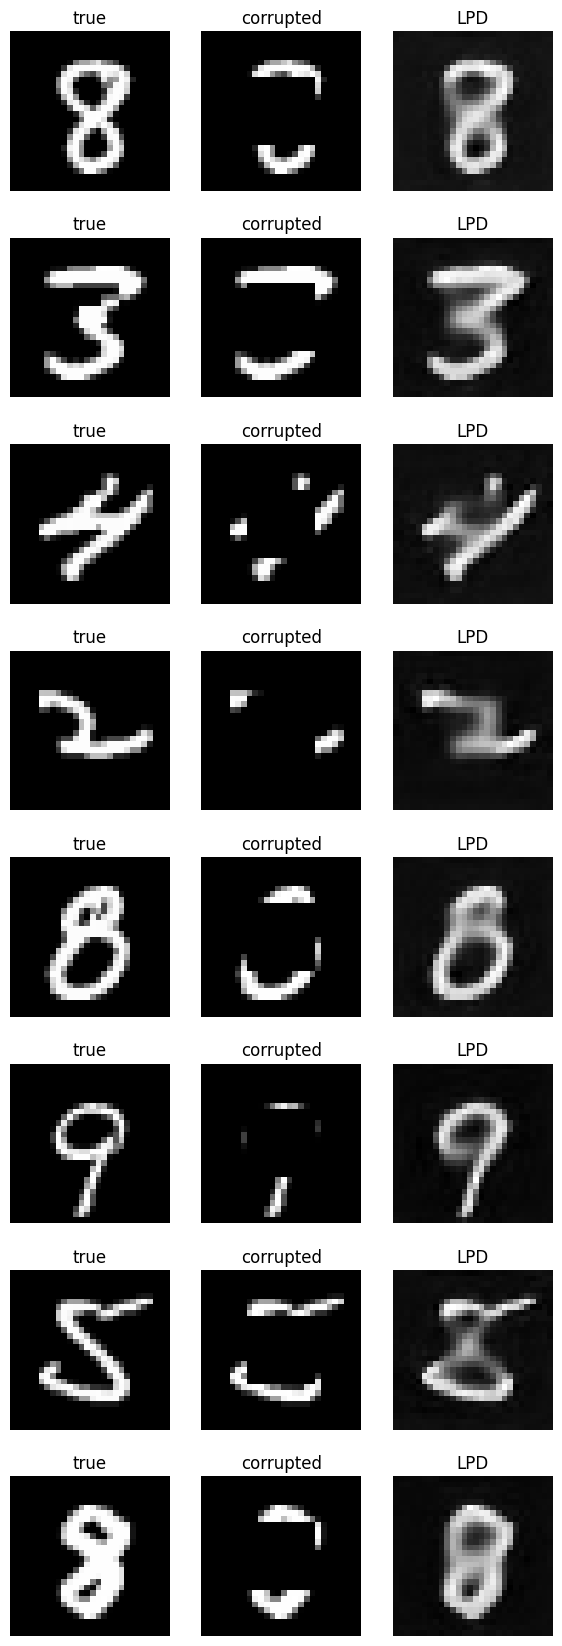

In [ ]:
### see how it performs on test images
for batch_idx, (x_true, _) in enumerate(test_dataloader):
    x_true = x_true.to(device)
    y = fwd_op(x_true)
    x_init = torch.zeros_like(x_true).to(device)

    x_recon = lpd_net(y, x_init) # reconstruct using the trained network

    num_samples = 8  # Limit to a few samples for visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(7, 21))
    ### let's see the images
    for i in range(num_samples):
        # Plot sinogram
        axes[i, 0].imshow((x_true[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 0].set_title('true')

        # Plot corrupted
        axes[i, 1].imshow((y[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 1].set_title('corrupted')

        # Plot ground truth image
        axes[i, 2].imshow((x_recon[i].detach().cpu().squeeze()), cmap='gray')
        axes[i, 2].set_title('LPD')

        # Remove axis ticks
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')

    plt.show()
    break